# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Defining-the-Hypoxia-Response" data-toc-modified-id="Defining-the-Hypoxia-Response-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Defining the Hypoxia Response</a></div><div class="lev1 toc-item"><a href="#Enrichment-Analysis-of-the-Global-HIF-1-response" data-toc-modified-id="Enrichment-Analysis-of-the-Global-HIF-1-response-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Enrichment Analysis of the Global HIF-1 response</a></div><div class="lev1 toc-item"><a href="#Enrichment-Analyses-of-the-egl-9-transcriptome" data-toc-modified-id="Enrichment-Analyses-of-the-egl-9-transcriptome-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Enrichment Analyses of the <em>egl-9</em> transcriptome</a></div><div class="lev1 toc-item"><a href="#Enrichment-Analysis-of-the-vhl-1-transcriptome" data-toc-modified-id="Enrichment-Analysis-of-the-vhl-1-transcriptome-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Enrichment Analysis of the <em>vhl-1</em> transcriptome</a></div><div class="lev1 toc-item"><a href="#Enrichment-Analysis-of-the-hif-1-exclusive-transcriptome" data-toc-modified-id="Enrichment-Analysis-of-the-hif-1-exclusive-transcriptome-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Enrichment Analysis of the <em>hif-1</em> exclusive transcriptome</a></div>

In [1]:
# important stuff:
import os
import pandas as pd
import numpy as np

# TEA and morgan
import tissue_enrichment_analysis as tea
import morgan as morgan
import gvars 

# Graphics
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

# Magic function to make matplotlib inline;
# other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline. 
# There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

ft = 35 #title fontsize
import genpy

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [2]:
q = 0.1

# this loads all the labels we need
genvar = gvars.genvars()

In [21]:
tissue_df = tea.fetch_dictionary()
phenotype_df = pd.read_csv('../input/phenotype_ontology.csv')
go_df = pd.read_csv('../input/go_dictionary.csv')
respiratory_complexes = pd.read_excel('../input/respiratory_complexes.xlsx')

In [3]:
# Specify the genotypes to refer to:
single_mutants = ['b', 'c', 'd', 'e', 'g']
# Specify which genotypes are double mutants 
# and of what single mutants:
double_mutants = {'a' : 'bd', 'f':'bc'}

# initialize the morgan.hunt object:
thomas = morgan.hunt('target_id', 'b', 'tpm', 'qval')

# input the genmap file:
thomas.add_genmap('../input/library_genotype_mapping.txt', comment='#')

# add the names of the single mutants
thomas.add_single_mutant(single_mutants)

# add the names of the double mutants
thomas.add_double_mutants(['a', 'f'], ['bd', 'bc'])

# set the q-value threshold for significance to its default value, 0.1
thomas.set_qval()

# Add the tpm files: 
kallisto_loc = '../input/kallisto_all/'
thomas.add_tpm(kallisto_loc, '/kallisto/abundance.tsv', '')

# Make all possible combinations of WT, X
combs = {}
for gene in thomas.genmap.genotype.unique():
    if gene != 'wt':
        combs[gene] = 'WT_'+gene+'/'

# load all the beta values for each genotype:
sleuth_loc = '../sleuth_all_adjusted/kallisto/'
for file in os.listdir("../sleuth_all_adjusted/kallisto"):
    if file[:4] == 'beta':
        letter = file[-5:-4].lower()
        thomas.add_beta(sleuth_loc + file, letter)
        thomas.beta[letter].sort_values('target_id', inplace=True)
        thomas.beta[letter].reset_index(inplace=True)

In [4]:
thomas.filter_data(0, 0.1)

In [5]:
frames = []
for key, df in thomas.beta.items():
    df['genotype'] = genvar.mapping[key]
    df['code'] = key
    frames += [df]
    df['sorter'] = genvar.sort_muts[key]
tidy = pd.concat(frames)
tidy.sort_values('sorter', inplace=True)

# Defining the Hypoxia Response

In [37]:
hyp_response = epi.find_overlap(['e', 'b', 'a', 'd'], tidy)
print(len(hyp_response))
tidy[(tidy.target_id.isin(hyp_response)) & (tidy.code == 'a')][['target_id', 'ens_gene', 'ext_gene']].to_csv('../output/hypoxia_response.csv', index=False)
hyp_response = tidy[tidy.target_id.isin(hyp_response)].ens_gene.unique()
print('There are {0} genes in the predicted hypoxia response'.format(len(hyp_response)))

391
There are 367 genes in the predicted hypoxia response


# Enrichment Analysis of the Global HIF-1 response

In [22]:
teaH = tea.enrichment_analysis(hyp_response, tissue_df, show=False)
peaH = tea.enrichment_analysis(hyp_response, phenotype_df, show=False)
geaH = tea.enrichment_analysis(hyp_response, go_df, show=False)

In [23]:
geaH

,Tissue,Expected,Observed,Enrichment Fold Change,P value,Q value
78,cytoplasm GO:0005737,69.768976,113,1.619631,3.653604e-07,0.000099
193,oxoacid metabolic process GO:0043436,7.880952,24,3.045317,5.726098e-07,0.000099
58,"oxidoreductase activity, acting on CH-OH group...",1.224017,8,6.535856,3.403822e-06,0.000306
158,mitochondrion GO:0005739,11.638900,29,2.491644,3.429310e-06,0.000306
146,immune system process GO:0002376,6.979045,20,2.865722,9.913333e-06,0.000535
46,flavin adenine dinucleotide binding GO:0050660,1.503179,8,5.322054,1.916294e-05,0.000862
152,protein folding GO:0006457,2.082977,9,4.320740,4.730130e-05,0.001824
14,iron ion binding GO:0005506,2.598352,10,3.848593,6.457967e-05,0.002180
147,extracellular region GO:0005576,12.240171,25,2.042455,3.356117e-04,0.009921
101,carbohydrate binding GO:0030246,6.463669,16,2.475374,3.307005e-04,0.009921


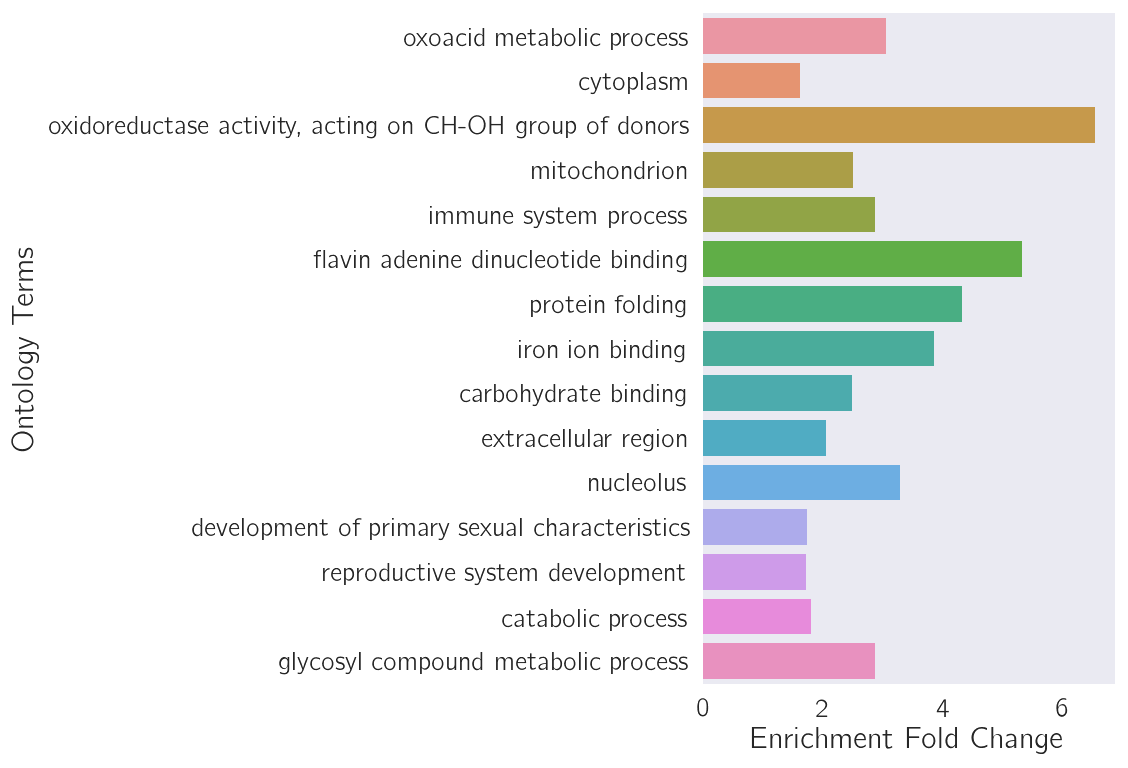

In [24]:
tea.plot_enrichment_results(geaH, analysis='go')

In [25]:
teaH

,Tissue,Expected,Observed,Enrichment Fold Change,P value,Q value
183,cephalic sheath cell WBbt:0008406,6.557332,17,2.592518,0.000130,0.035403
36,uterine seam cell WBbt:0006789,0.908937,5,5.500931,0.000274,0.037374


# Enrichment Analyses of the *egl-9* transcriptome

In [26]:
egl = thomas.beta['b']
teaEgl = tea.enrichment_analysis(egl[egl.qval < q].ens_gene.unique(), tissue_df, show=False)
peaEgl = tea.enrichment_analysis(egl[egl.qval < q].ens_gene.unique(), phenotype_df, show=False)
geaEgl = tea.enrichment_analysis(egl[egl.qval < q].ens_gene.unique(), go_df, show=False)

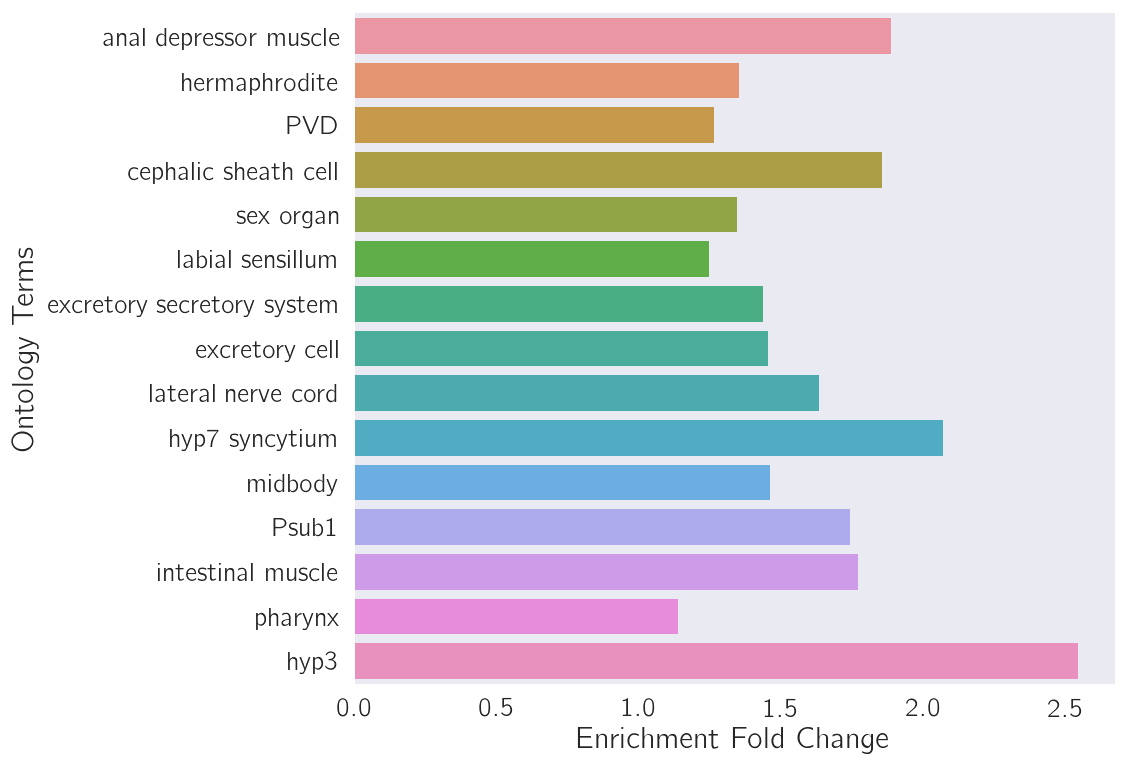

In [27]:
tea.plot_enrichment_results(teaEgl)

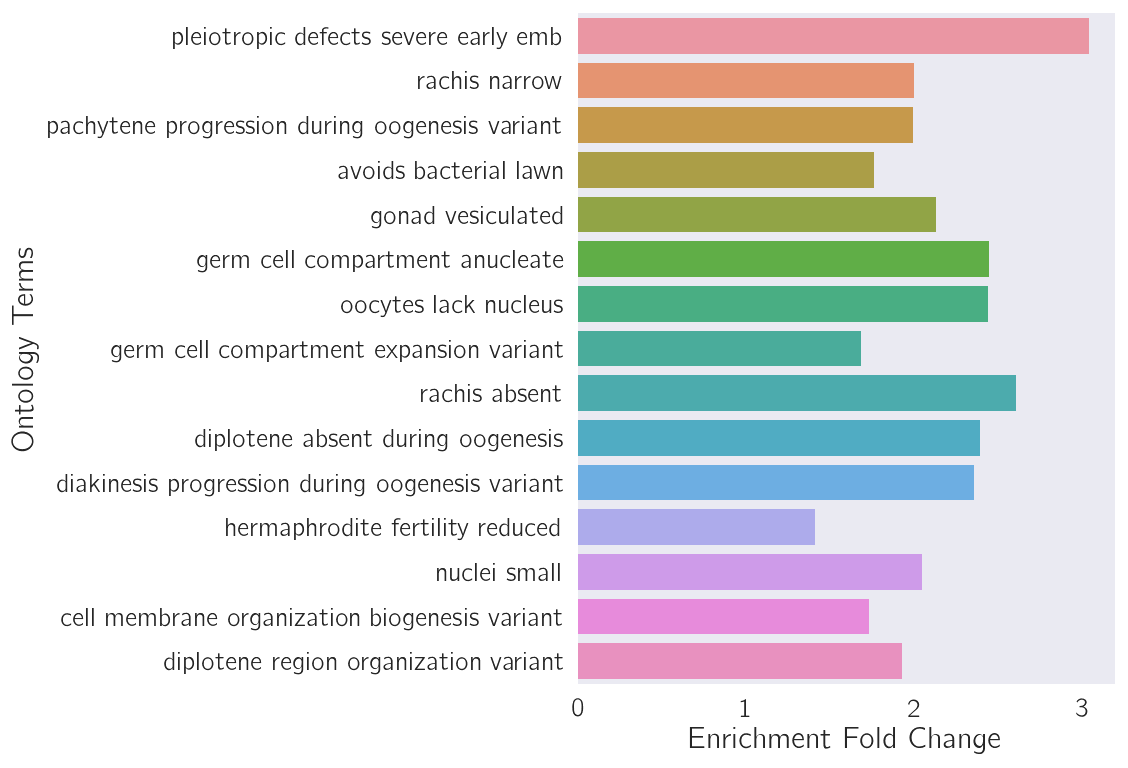

In [28]:
tea.plot_enrichment_results(peaEgl, analysis='phenotype')

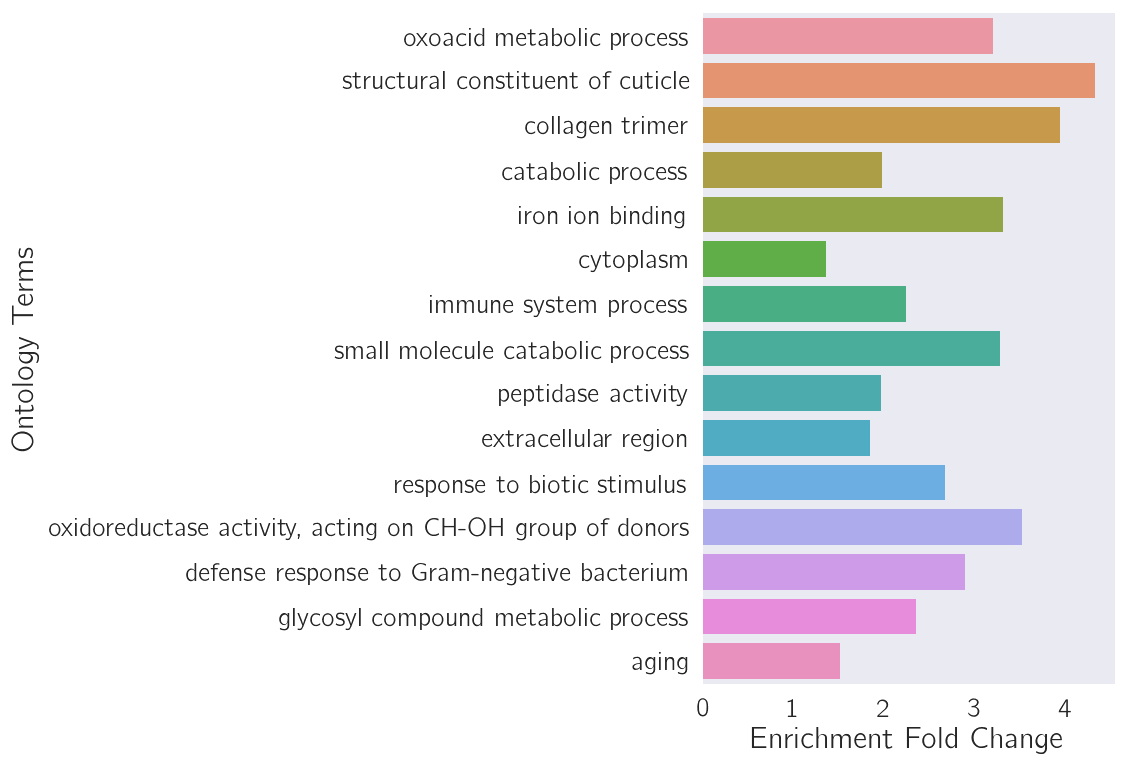

In [29]:
tea.plot_enrichment_results(geaEgl, analysis='go')

# Enrichment Analysis of the *vhl-1* transcriptome

In [30]:
vhl = thomas.beta['d']
teaVhl = tea.enrichment_analysis(vhl[vhl.qval < 0.1].ens_gene.unique(), tissue_df, show=False)
peaVhl = tea.enrichment_analysis(vhl[vhl.qval < 0.1].ens_gene.unique(), phenotype_df, show=False)
geaVhl = tea.enrichment_analysis(vhl[vhl.qval < 0.1].ens_gene.unique(), go_df, show=False)

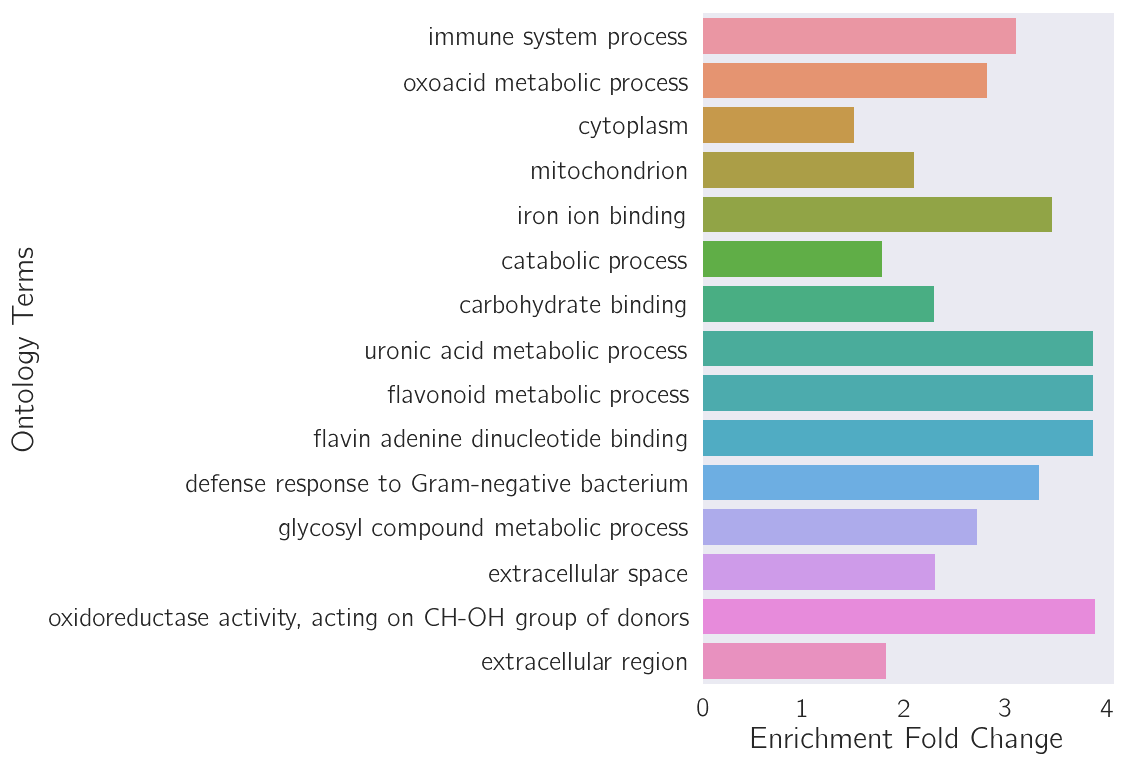

In [31]:
tea.plot_enrichment_results(geaVhl, analysis='go')

# Enrichment Analysis of the *hif-1* exclusive transcriptome

This refers to the genes that are downstream of *hif-1* but not downstream of *egl-9*, *vhl-1* or *rhy-1*.

In [32]:
hif = thomas.beta['c']
teahif = tea.enrichment_analysis(hif[hif.qval < 0.1].ens_gene.unique(), tissue_df, show=False)
peahif = tea.enrichment_analysis(hif[hif.qval < 0.1].ens_gene.unique(), phenotype_df, show=False)
geahif = tea.enrichment_analysis(hif[hif.qval < 0.1].ens_gene.unique(), go_df, show=False)

In [33]:
tea.plot_enrichment_results(teahif, analysis='tissue')

dataframe is empty!


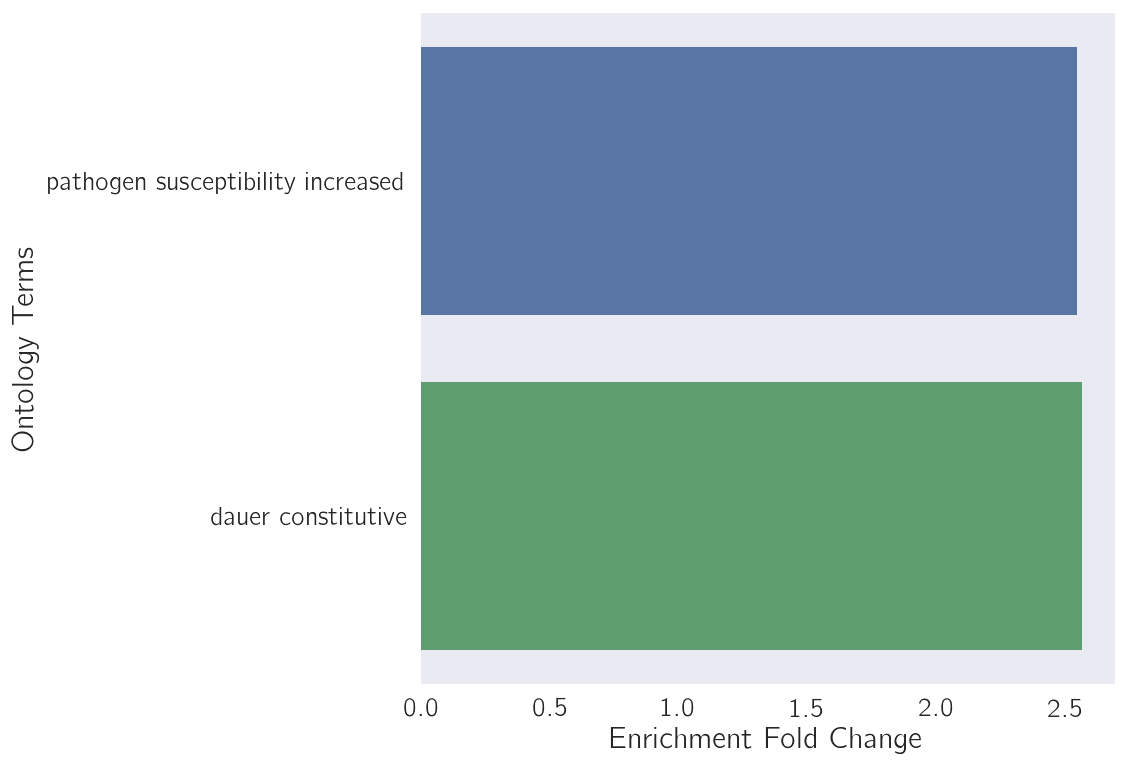

In [34]:
tea.plot_enrichment_results(peahif, analysis='phenotype')

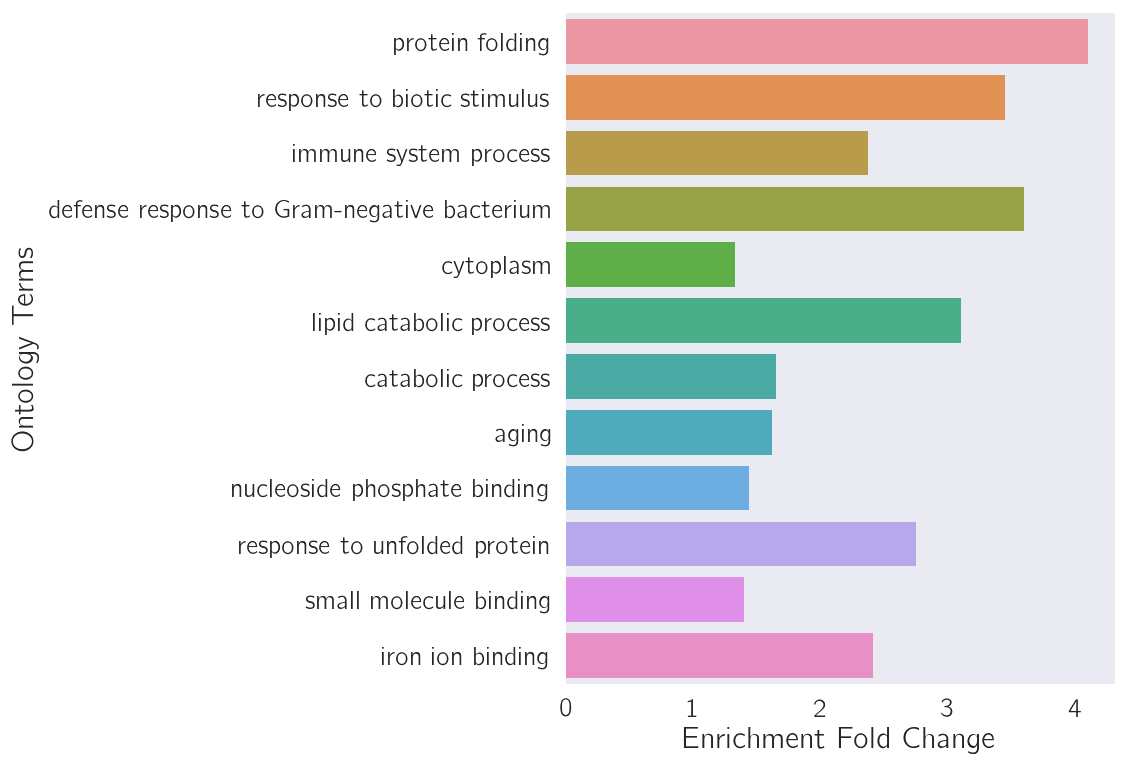

In [35]:
tea.plot_enrichment_results(geahif, analysis='go')